# **Intelligent Campus Surveillance (ICS)**

In [1]:
#Neccessary Imports

import os
import cv2
import pickle
import numpy as np
import face_recognition


In [2]:

#Save encodings
def saveEncodings(encs,names,fname="encodings.pickle"):
    """
    Save encodings in a pickle file to be used in future.

    Parameters
    ----------
    encs : List of np arrays
        List of face encodings.
    names : List of strings
        List of names for each face encoding.
    fname : String, optional
        Name/Location for pickle file. The default is "encodings.pickle".

    Returns
    -------
    None.

    """
    
    data=[]
    d = [{"name": nm, "encoding": enc} for (nm, enc) in zip(names, encs)]
    data.extend(d)

    encodingsFile=fname
    
    # dump the facial encodings data to disk
    print("[INFO] serializing encodings...")
    f = open(encodingsFile, "wb")
    f.write(pickle.dumps(data))
    f.close()    


In [3]:

#Function to read encodings
def readEncodingsPickle(fname):
    """
    Read Pickle file.

    Parameters
    ----------
    fname : String
        Name of pickle file.(Full location)

    Returns
    -------
    encodings : list of np arrays
        list of all saved encodings
    names : List of Strings
        List of all saved names

    """
    
    data = pickle.loads(open(fname, "rb").read())
    data = np.array(data)
    encodings = [d["encoding"] for d in data]
    names=[d["name"] for d in data]
    return encodings,names


In [4]:

#Function to create encodings and get face locations
def createEncodings(image):
    """
    Create face encodings for a given image and also return face locations in the given image.

    Parameters
    ----------
    image : cv2 mat
        Image you want to detect faces from.

    Returns
    -------
    known_encodings : list of np array
        List of face encodings in a given image
    face_locations : list of tuples
        list of tuples for face locations in a given image

    """
    
    #Find face locations for all faces in an image
    face_locations = face_recognition.face_locations(image, model="cnn")

    print("Number of faces detected:", len(face_locations))

    #Create encodings for all faces in an image
    known_encodings=face_recognition.face_encodings(image,known_face_locations=face_locations)
    return known_encodings,face_locations


In [5]:

#Function to compare encodings
def compareFaceEncodings(unknown_encoding,known_encodings,known_names):
    """
    Compares face encodings to check if 2 faces are same or not.

    Parameters
    ----------
    unknown_encoding : np array
        Face encoding of unknown people.
    known_encodings : np array
        Face encodings of known people.
    known_names : list of strings
        Names of known people

    Returns
    -------
    acceptBool : Bool
        face matched or not
    duplicateName : String
        Name of matched face
    distance : Float
        Distance between 2 faces

    """
    duplicateName=""
    distance=0.0
    matches = face_recognition.compare_faces(known_encodings, unknown_encoding,tolerance=0.5)
    face_distances = face_recognition.face_distance(known_encodings, unknown_encoding)
    best_match_index = np.argmin(face_distances)
    distance=face_distances[best_match_index]
    if matches[best_match_index]:
        acceptBool=True
        duplicateName=known_names[best_match_index]
    else:
        acceptBool=False
        duplicateName=""
    return acceptBool,duplicateName,distance


In [6]:

#Save Image to new directory
def saveImageToDirectory(image,name,imageName):
    """
    Saves images to directory.

    Parameters
    ----------
    image : cv2 mat
        Image you want to save.
    name : String
        Directory where you want the image to be saved.
    imageName : String
        Name of image.

    Returns
    -------
    None.

    """
    path=r"Facedata\saved_img"+name
    if os.path.exists(path):
        pass
    else:
        os.mkdir(path)
    cv2.imwrite(path+"/"+imageName,image)
    



In [7]:
def processKnownPeopleImages(path=r"Facedata\People",saveLocation="./known_encodings.pickle"):
    """
    Process images of known people and create face encodings to compare in future.
    Eaach image should have just 1 face in it.

    Parameters
    ----------
    path : STRING, optional
        Path for known people dataset. The default is "./People".
        It should be noted that each image in this dataset should contain only 1 face.
    saveLocation : STRING, optional
        Path for storing encodings for known people dataset. The default is "./known_encodings.pickle in current directory".

    Returns
    -------
    None.

    """
    
    known_encodings=[]
    known_names=[]
    for img in os.listdir(path):
        imgPath=os.path.join(path, img)
        print("Loading image:", imgPath)
        mage = cv2.imread(imgPath)

        #Read image
        image=cv2.imread(imgPath)
        name=img.rsplit('.')[0]
        #Resize
        image=cv2.resize(image,(0,0),fx=0.2,fy=0.2,interpolation=cv2.INTER_LINEAR)
        
        #Get locations and encodings
        encs,locs=createEncodings(image)
        
        known_encodings.append(encs[0])
        known_names.append(name)
        
        for loc in locs:
            top, right, bottom, left=loc
            
        #Show Image
        cv2.rectangle(image,(left,top),(right,bottom),color=(255,0,0),thickness=2)
        cv2.imshow("Image",image)
        cv2.waitKey(1)
        cv2.destroyAllWindows()
    saveEncodings(known_encodings,known_names,saveLocation)

In [8]:
def processLiveCCTV():
    # Load known face encodings and names
    known_encodings, names = readEncodingsPickle("./known_encodings.pickle")
    
    # Open the live video feed (use the appropriate camera index or video file)
    cap = cv2.VideoCapture(0)  # 0 for default camera
    
    # Counter to keep track of the number of images saved
    images_saved = 0
    
    while images_saved < 3:
        # Read a frame from the live feed
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize the frame for faster processing
        small_frame = cv2.resize(frame, (0, 0), fx=0.2, fy=0.2)
        
        # Get face locations and encodings
        encs, locs = createEncodings(small_frame)
        
        # Process each face in the frame
        for i, loc in enumerate(locs):
            top, right, bottom, left = [coord * 5 for coord in loc]  # Upscale coordinates
            unknown_encoding = encs[i]
            
            # Compare with known encodings
            accept_bool, duplicate_name, distance = compareFaceEncodings(unknown_encoding, known_encodings, names)
            
            if accept_bool:
                # Save the frame to a directory with the person's name
                saveImageToDirectory(frame, duplicate_name, f"{duplicate_name}_{distance:.2f}.jpg")
                
                # Increment the counter
                images_saved += 1
        
        # Display the processed frame
        cv2.imshow("Live CCTV Feed", frame)
        
        if images_saved >= 3:
            # Break the loop after saving three images
            break
        
        if cv2.waitKey(1) & 0xFF == ord("q"):
            break
    
    # Release the video capture and close windows
    cap.release()
    cv2.destroyAllWindows()


In [9]:
from roboflow import Roboflow
from IPython.display import Image, display
import os
import cv2

def addTextToImage(image_path, text):
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Add text to the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    bottom_left_corner = (10, 30)
    font_scale = 1
    font_color = (255, 255, 255)  # White color
    line_type = 2

    cv2.putText(img, text, bottom_left_corner, font, font_scale, font_color, line_type)

    # Save the modified image
    cv2.imwrite(image_path, img)

def detectLanyardID():
    """
    Detect lanyard/ID card in the saved images from the live CCTV feed.

    Returns
    -------
    None.

    """
    rf = Roboflow(api_key="5G5FnVtCZXZN25njnls4")
    project = rf.workspace().project("id-card-detection-v1")
    model = project.version(1).model
    
    # Specify the absolute path to the "facedata" folder
    facedata_path = r"Facedata"  # Replace with the actual path
    
    # Look for folders starting with "saved_img" within "facedata"
    for folder_name in os.listdir(facedata_path):
        if folder_name.startswith("saved_img"):
            # Get the path where the images from the live CCTV feed are saved
            images_saved_path = os.path.join(facedata_path, folder_name)
            
            # Process each image in the folder
            for img_name in os.listdir(images_saved_path):
                img_path = os.path.join(images_saved_path, img_name)
                
                # Infer on the local image
                prediction = model.predict(img_path, confidence=40, overlap=30)

                # Save the image with the ID card detection
                output_image_path = f"{img_name.split('.')[0]}_with_id_card.jpg"
                prediction.save(output_image_path)
                
                # Add text to the image if ID card is detected
                if len(prediction) > 0:
                    addTextToImage(output_image_path, "VIT ID/Tag detected")
                
                # Display the output image in the notebook
                display(Image(output_image_path))


Loading image: Facedata\People\nithin.jpg
Number of faces detected: 1
[INFO] serializing encodings...
Number of faces detected: 1
Number of faces detected: 1
Number of faces detected: 1
loading Roboflow workspace...
loading Roboflow project...


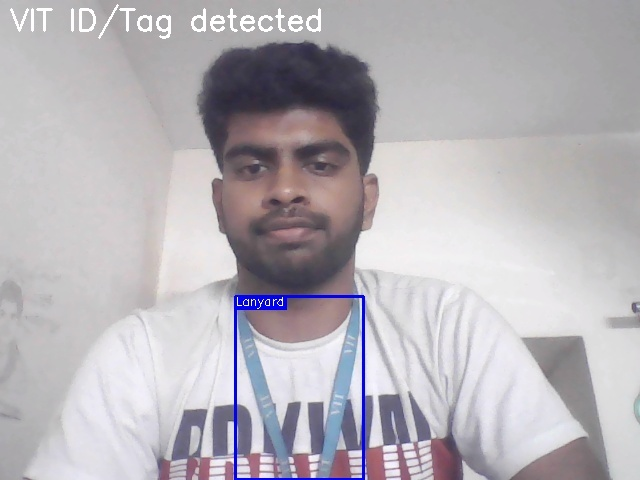

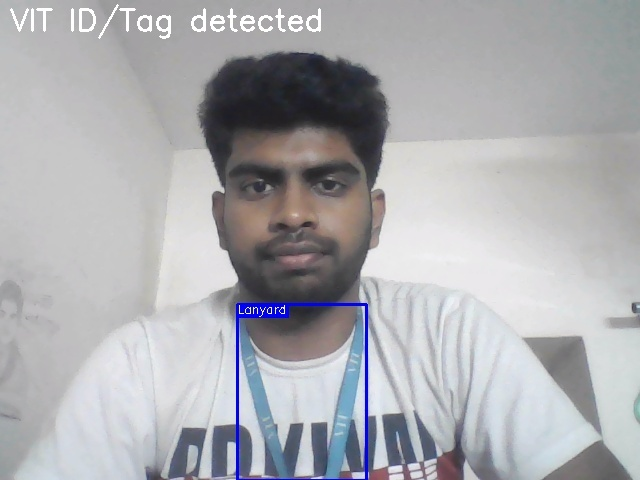

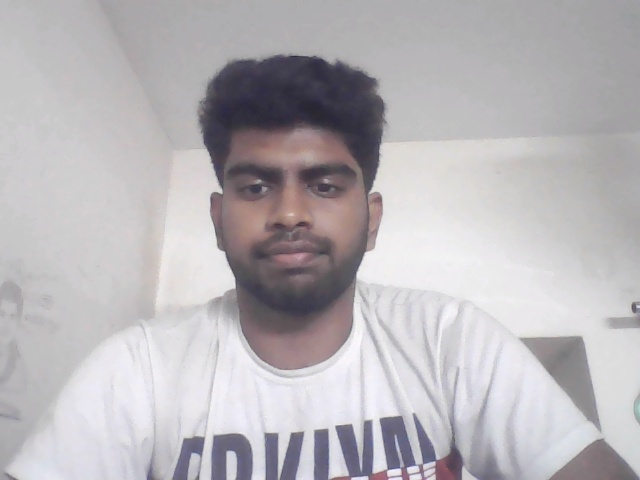

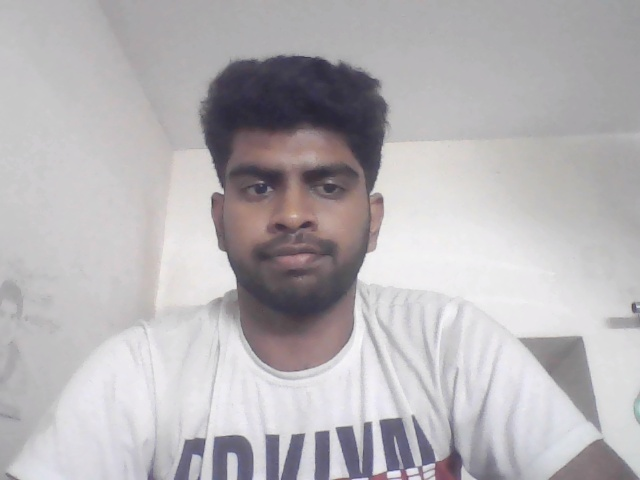

Completed


In [10]:
def main():
    """
    Main Function.

    Returns
    -------
    None.

    """
    #datasetPath="./Dataset/"
    peoplePath=r"Facedata\People"
    processKnownPeopleImages(path=peoplePath)
    #processDatasetImages(path=datasetPath)
    processLiveCCTV()
    detectLanyardID()
    print("Completed")

if __name__=="__main__":
    main()  